In [1]:
import osmnx as ox
import networkx as nx
from pyproj import CRS
from shapely.strtree import STRtree
from shapely.geometry import Point

import requests
import time

import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# # fetch graph from OSM defined by a bounding box
# G = ox.graph_from_bbox(51.5284, 51.4176, -0.0673, -0.3080, network_type='bike')
# G = ox.project_graph(G)
# G = ox.add_edge_speeds(G)
# G = ox.add_edge_travel_times(G)

def add_node_elevations(G, max_locations_per_batch=200, pause_duration=0, precision=3):
    """
    Add `elevation` (meters) attribute to each node using a web service.
    This uses the Open Elevation API.
    Parameters
    ----------
    G : networkx.MultiDiGraph
        input graph
    max_locations_per_batch : int
        max number of coordinate pairs to submit in each API call (if this is
        too high, the server will reject the request because its character
        limit exceeds the max allowed)
    pause_duration : float
        time to pause between API calls, which can be increased if you get
        rate limited
    precision : int
        decimal precision to round elevation values
    Returns
    -------
    G : networkx.MultiDiGraph
        graph with node elevation attributes
    """

    url_template = "https://api.open-elevation.com/api/v1/lookup?locations={}"

    # make a pandas series of all the nodes' coordinates as 'lat,lng'
    # round coordinates to 5 decimal places (approx 1 meter) to be able to fit
    # in more locations per API call
    node_points = pd.Series(
        {node: f'{data["lat"]:.5f},{data["lon"]:.5f}' for node, data in G.nodes(data=True)}
    )
    n_calls = int(np.ceil(len(node_points) / max_locations_per_batch))
    ox.utils.log(f"Requesting node elevations from the API in {n_calls} calls")

    # break the series of coordinates into chunks of size max_locations_per_batch
    # API format is locations=lat,lng|lat,lng|lat,lng|lat,lng...
    results = []
    for i in range(0, len(node_points), max_locations_per_batch):
        print(f"Fetching chunk {i/max_locations_per_batch:.0f} of {len(node_points)/max_locations_per_batch:.0f}....")
        chunk = node_points.iloc[i : i + max_locations_per_batch]

        locations = "|".join(chunk)
        url = url_template.format(locations)

        # check if this request is already in the cache (if global use_cache=True)
        cached_response_json = ox.downloader._retrieve_from_cache(url)
        if cached_response_json is not None:
            response_json = cached_response_json
        else:
            try:
                # request the elevations from the API
                time.sleep(pause_duration)

                response = requests.get(url)
                response_json = response.json()
                ox.downloader._save_to_cache(url, response_json, response.status_code)

                # append these elevation results to the list of all results
                results.extend(response_json["results"])

            except Exception as e:
                print(e)
                print(f"Server responded with {response.status_code}: {response.reason}")
                i = i - max_locations_per_batch


    # sanity check that all our vectors have the same number of elements
    if not (len(results) == len(G) == len(node_points)):
        raise Exception(
            f"Graph has {len(G)} nodes but we received {len(results)} results from elevation API"
        )
    else:
        print(f"Graph has {len(G)} nodes and we received {len(results)} results from elevation API")

    # add elevation as an attribute to the nodes
    df = pd.DataFrame(node_points, columns=["node_points"])
    df["elevation"] = [result["elevation"] for result in results]
    df["elevation"] = df["elevation"].round(precision)

    nx.set_node_attributes(G, name="elevation", values=df["elevation"].to_dict())
    ox.utils.log("Added elevation data from web service to all nodes.")

    return G

# # fetch node elevations to calculate edge grades
# G = add_node_elevations(G, max_locations_per_batch=100, pause_duration=2)
# G = ox.elevation.add_edge_grades(G)
# grades = pd.Series([d["grade_abs"] for _, _, d in ox.get_undirected(G).edges(data=True)])
# grades = grades.replace([np.inf, -np.inf], 0).dropna()

# # save the graph
# ox.save_graphml(G, './data/London.graphml')

# load a pre-fetched graph
G = ox.load_graphml('./data/London.graphml')
nodes, edges = ox.graph_to_gdfs(G)

In [36]:
# read a cleaned commute file
subject = 'B'
file = '1805PM'
df = pd.read_csv('../Commute Monitoring/'+subject+'/Cleaned/'+file+'.csv')

# create a DataFrame of latitude and longitude values
lats = df['Lat'].to_list()
lngs = df['Lng'].to_list()
points_list = [Point((lng, lat)) for lat, lng in zip(lats, lngs)]
points = geopandas.GeoSeries(points_list, crs='epsg:4326')

# re-project the graph back to co-ordinate space
G = ox.project_graph(G, to_crs='4326') 

# find the nearest edge to each lat-lng pair
nearest_edges = ox.nearest_edges(G, [pt.x for pt in points], [pt.y for pt in points])

In [37]:
# create a DataFrame containing the point, corresponding edge, and PM2.5 concentration
pts = geopandas.GeoDataFrame({'Geometry': points, 'Nearest Edge': nearest_edges, 'PM2.5':df['PM2.5']})

# collect other relevant edge attributes for future modelling
pts['greenness'] = pts['Nearest Edge'].apply(lambda x: edges.loc[x].greenness)
pts['highway'] = pts['Nearest Edge'].apply(lambda x: edges.loc[x].highway)
pts['lanes'] = pts['Nearest Edge'].apply(lambda x: edges.loc[x].lanes)

# remove duplicate edge entries in the DataFrame
edge_pollute = pts.groupby(['Nearest Edge']).first()
edge_pollute['PM2.5'] = pts.groupby(['Nearest Edge']).mean()
edge_pollute.index = pd.MultiIndex.from_tuples(edge_pollute.index, names=('u', 'v', 'key'))

def eval_lanes(x):
    '''
    Returns an integer number of lanes, parsing OSM's list attribute.

            Parameters:
                    x (int or list): Raw OSM number of lanes attribute

            Returns:
                    x (int): Integer number of lanes representing the minimum value in the list.
    '''
    if type(x) == list:
        return min([int(x) for x in eval(str(x))])
    else:
        return x

edge_pollute['lanes'] = edge_pollute['lanes'].apply(eval_lanes)


In [38]:
# assign the measured PM2.5 values to the graph edges
edges['PM2.5'] = np.nan
edges.loc[edge_pollute.index, 'PM2.5'] = edge_pollute['PM2.5']
edges['lanes'] = edges['lanes'].apply(eval_lanes)

4.0 1.0


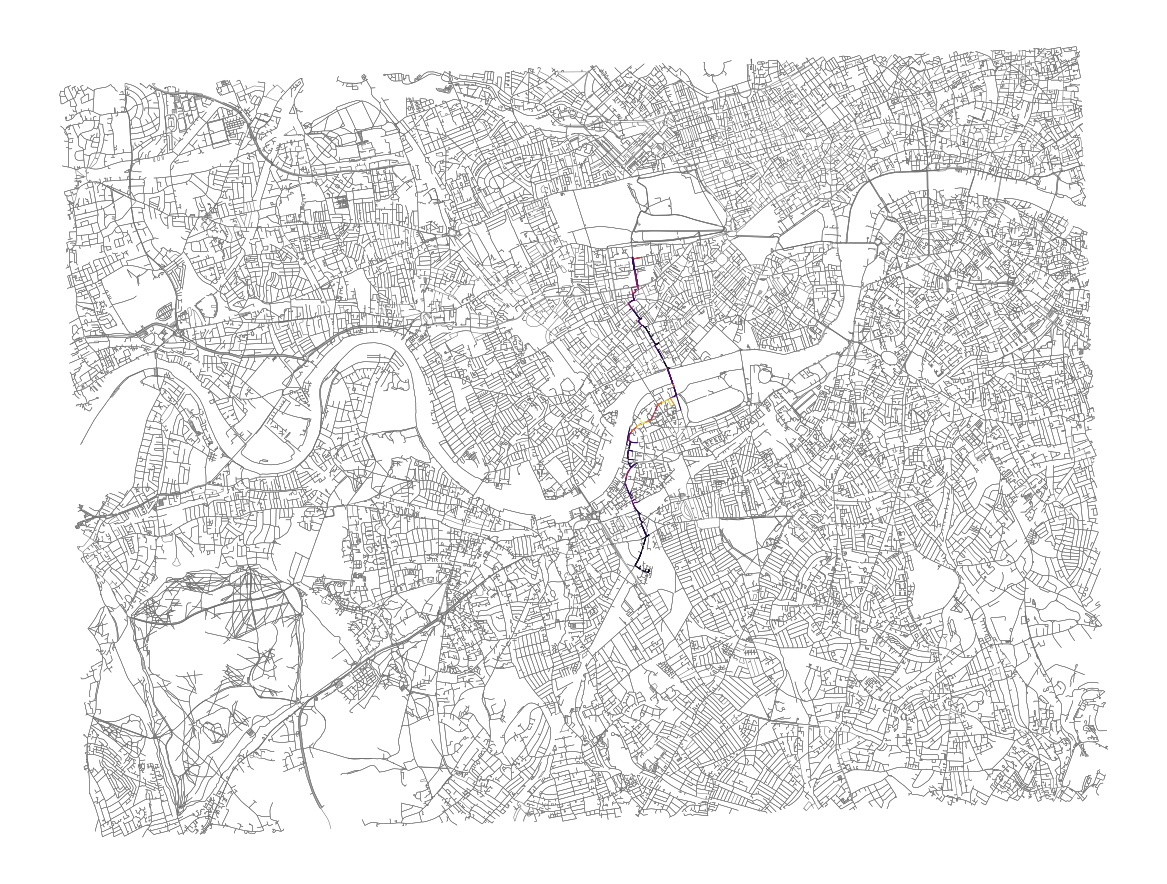

In [39]:
# plot the commute heatmap
fig, ax = plt.subplots(figsize=(24,16))
ax.set_axis_off()
edges.plot(ax=ax, linewidth=0.5, edgecolor='dimgray')
edges.loc[pts['Nearest Edge']].plot(ax=ax, linewidth=1, column='PM2.5', cmap='inferno')

plt.savefig('../Commute Monitoring/'+subject+'/img/'+subject+'_'+file+'.png', bbox_inches='tight', pad_inches=0)